In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

### Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [2]:
df = pd.read_csv("churn_data.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [6]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


In [9]:
# Ананлогичный пример для вещественного признака

In [10]:
tenure =  Pipeline([
                ('selector', NumberSelector(key='Tenure'))
            ])

tenure.fit(X_train)
tenure.transform(X_test)[:8]

,Tenure
9394,8
898,2
2398,8
5906,4
2343,5
8225,3
5506,0
6451,6


In [11]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [12]:
final_transformers

[('Geography',
  Pipeline(steps=[('selector', FeatureSelector(column='Geography')),
                  ('ohe', OHEEncoder(key='Geography'))])),
 ('Gender',
  Pipeline(steps=[('selector', FeatureSelector(column='Gender')),
                  ('ohe', OHEEncoder(key='Gender'))])),
 ('Tenure',
  Pipeline(steps=[('selector', FeatureSelector(column='Tenure')),
                  ('ohe', OHEEncoder(key='Tenure'))])),
 ('HasCrCard',
  Pipeline(steps=[('selector', FeatureSelector(column='HasCrCard')),
                  ('ohe', OHEEncoder(key='HasCrCard'))])),
 ('IsActiveMember',
  Pipeline(steps=[('selector', FeatureSelector(column='IsActiveMember')),
                  ('ohe', OHEEncoder(key='IsActiveMember'))])),
 ('CreditScore',
  Pipeline(steps=[('selector', NumberSelector(key='CreditScore'))])),
 ('Age', Pipeline(steps=[('selector', NumberSelector(key='Age'))])),
 ('Balance', Pipeline(steps=[('selector', NumberSelector(key='Balance'))])),
 ('NumOfProducts',
  Pipeline(steps=[('selector', Numbe

In [13]:
feats = FeatureUnion(final_transformers)

In [14]:
feature_processing = Pipeline([('feats', feats)])

In [15]:
feature_processing

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
              

In [16]:
# Теперь у нас есть пайплайн, который готовит признаки для моделирования.Добавим модель

In [17]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [18]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [19]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [20]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


In [21]:
thresholds1 = thresholds[ix] 
fscore1 = fscore[ix]
precision1 = precision[ix]
recall1 = recall[ix]

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


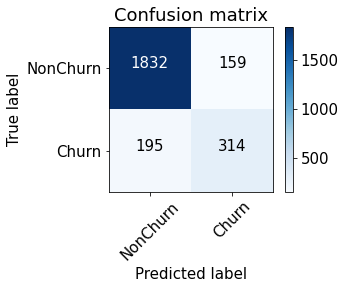

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()


### Для нашего пайплайна поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков

In [23]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

### GradientBoostingClassifier

In [24]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [25]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


In [27]:
thresholds2 = thresholds[ix] 
fscore2 = fscore[ix]
precision2 = precision[ix]
recall2 = recall[ix]

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


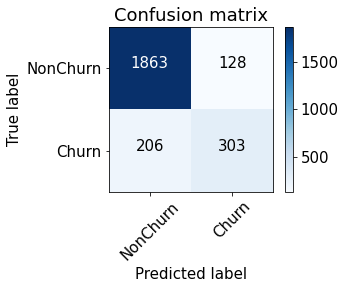

In [28]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix1 = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix1, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### Logistic Regression

In [29]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


In [31]:
thresholds3 = thresholds[ix] 
fscore3 = fscore[ix]
precision3 = precision[ix]
recall3 = recall[ix]

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


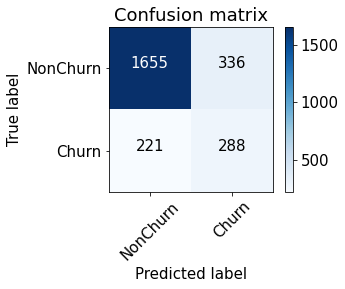

In [32]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [33]:
total_score = pd.DataFrame({
                      'Best Threshold':[thresholds1, thresholds2, thresholds3], 
                      'F-Score':[fscore1, fscore2, fscore3], 
                      'Precision':[precision1, precision2, precision3], 
                      'Recall':[recall1, recall2, recall3], 
                      }, index=['RandomForestClassifier', 'GradientBoosting', 'LogisticRegression'])
total_score.round(2)

,Best Threshold,F-Score,Precision,Recall
RandomForestClassifier,0.38,0.64,0.65,0.63
GradientBoosting,0.41,0.65,0.70,0.60
LogisticRegression,0.29,0.51,0.46,0.57


### Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [34]:
total_score.where(total_score['F-Score'] >= max(total_score['F-Score']))

,Best Threshold,F-Score,Precision,Recall
RandomForestClassifier,NaN,NaN,NaN,NaN
GradientBoosting,0.408508,0.646121,0.703704,0.59725
LogisticRegression,NaN,NaN,NaN,NaN


### Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [35]:
cnf_matrix

array([[1655,  336],
       [ 221,  288]])

In [36]:
TN, FN, TP, FP = cnf_matrix1[0][0],cnf_matrix1[1][0],cnf_matrix1[1][1],cnf_matrix1[0][1]

In [37]:
TN, FN, TP, FP

(1863, 206, 303, 128)

In [38]:
cost = TP + FP 
income = TP * 2  


In [39]:
print(f'Projected revenue: {income - cost}')

Projected revenue: 175


### (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3¶


In [40]:
from sklearn.model_selection import GridSearchCV

parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], 'n_estimators': [50, 100, 150],
              'min_samples_leaf':[1, 2, 5], 'max_depth':[2, 3, 4]}

gb = GradientBoostingClassifier(random_state = 42)
gs = GridSearchCV(gb, parameters)

pipeline = Pipeline([
    ('features', feats),
    ('classifier', gs),
])

pipeline.fit(X_train, y_train)

gs.best_params_, gs.best_score_

({'learning_rate': 0.2,
  'max_depth': 3,
  'min_samples_leaf': 2,
  'n_estimators': 100},
 0.8652)